# Imports

In [1]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

import os

import utils

print(tf.__version__)

2.10.0


# Load training images
Load images from the [assets] folder and scan them into arrays.

In [39]:
# Path to traning data
path = "../assets/train/"
# First file to analyze '0' is the first file in each directory
file_start = 0

# Number of files in each directory to load
file_count = 1500 # 1500

# Last file to load in each directory
file_end = file_start + file_count

# Numer of permutations for generating additional training data
num_permutations = 24

dirs = ["","","","","","","","","","","","","","","","","","","","","","","","",]
for i in range(num_permutations):
  dirs[i] = f"{utils.perms[i][0]:d}{utils.perms[i][1]:d}{utils.perms[i][2]:d}{utils.perms[i][3]:d}"

image_width = 128
image_height = 128

# Pre-allocate a large numpy array to store training data
training_images = np.zeros((file_count * len(dirs), image_width, image_height), dtype=np.float32)

# Store labels for the training images
training_labels = np.zeros(file_count * len(dirs))

# Missing offset (If file fails to open, avoid including empty arrays in the testing set with this offset)
miss = 0

# Iterate through each directory, loading [file_count] images from each into the [training_images] array
for i in range(len(dirs)):
  for j in range(file_start, file_end):
    # Parse a path for the file to load
    in_path = path + dirs[i] + "/" + f'{j:05d}' + ".png"
    try:
      # Graryscale the image to reduce data size given to the machine
      im = ImageOps.grayscale(Image.open(in_path))
    except FileNotFoundError:
      # Increment miss counter to avoid zero arrays in the training data
      miss += 1
      continue
    # Calculate index
    idx = i*file_count + j - miss
    temp_arr =  np.asarray(im, dtype=np.uint8)/255 # Normalize
    # Add images to training data
    training_images[idx] = temp_arr
    # Add label
    if dirs[i] == "0123":
      # Assign '1' for correct-ordered image
      training_labels[idx] = 1
    else:
      # Assign '0' for incorrect-ordered image
      training_labels[idx] = 0 
# Trim missing data off of the training data
training_images.resize((file_count * len(dirs) - miss, image_width, image_height))
training_labels.resize((file_count * len(dirs) - miss))

# Convert to unsigned integer
training_labels = training_labels.astype(np.uint8)

print(training_images.shape)


(36000, 128, 128)


# Preprocessing

Correct


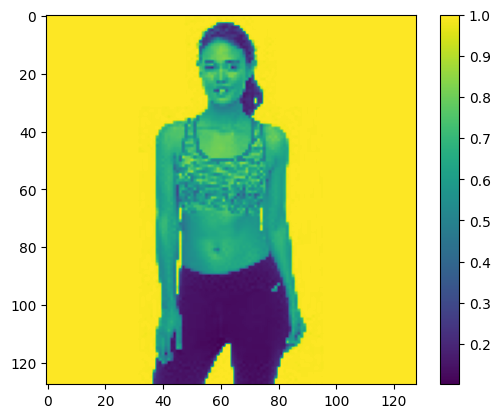

In [77]:
class_names = ['Incorrect', 'Correct']

idx = 10

res = training_images[idx]
print(class_names[training_labels[idx]])

plt.figure()
plt.imshow(res)
plt.colorbar()
plt.grid(False)
plt.show()


# Show additional images

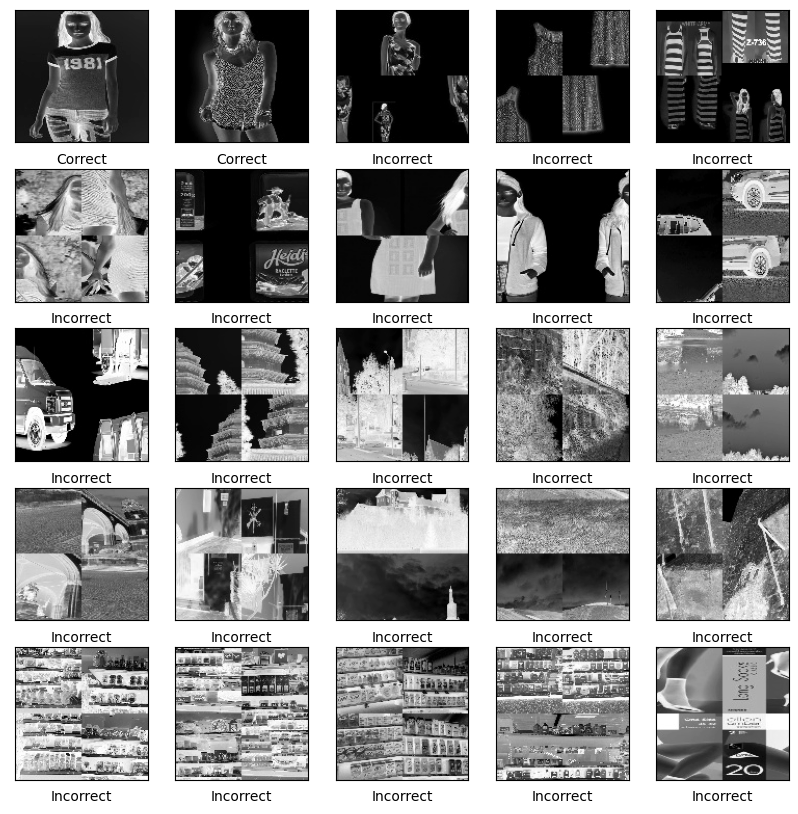

In [78]:
# Modified from https://www.tensorflow.org/tutorials/keras/classification
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(training_images[i*(int(len(training_labels)/25))], cmap=plt.cm.binary)
    plt.xlabel(class_names[training_labels[i*(int(len(training_labels)/25))]])
plt.show()

# Generate testing data

In [79]:
file_start = 0
file_end = 500

# Pre-allocate a large numpy array to store testing data
testing_images = np.zeros((file_end * len(dirs), image_width, image_height), dtype=np.float32)

# Store labels for the testing images
testing_labels = np.zeros(file_end * len(dirs))

# Missing offset (If file fails to open, avoid including empty arrays in the testing set with this offset)
miss = 0



# Iterate through each directory, loading [file_count] images from each into the [training_images] array
for i in range(len(dirs)):
  for j in range(file_start, file_end):
    # Parse a path for the file to load
    in_path = path + dirs[i] + "/" + f'{j + file_count:05d}' + ".png"
    try:
      # Graryscale the image to reduce data size given to the machine
      im = ImageOps.grayscale(Image.open(in_path))
    except FileNotFoundError:
      # Increment miss counter to avoid zero arrays in the training data
      miss += 1
      continue
    # Calculate index
    idx = i*file_end + j - miss
    temp_arr =  np.asarray(im, dtype=np.uint8)/255 # Normalize
    # Add images to training data
    testing_images[idx] = temp_arr
    # Add label
    if dirs[i] == "0123":
      # Assign '1' for correct-ordered image
      testing_labels[idx] = 1
    else:
      # Assign '0' for incorrect-ordered image
      testing_labels[idx] = 0 
# Trim missing data off of the training data
testing_images.resize((file_end * len(dirs) - miss, image_width, image_height))
testing_labels.resize((file_end * len(dirs) - miss))

# Convert to unsigned integer
testing_labels = testing_labels.astype(np.uint8)

print(testing_images.shape)


(12000, 128, 128)


# Setting up the layers

In [48]:
# Modified from https://www.tensorflow.org/tutorials/keras/classification
model = tf.keras.Sequential([
    # Unstacks the pixel rows of the images and lines them end to end 128x128 -> 16,384 pixels
    tf.keras.layers.Flatten(input_shape=(image_width, image_height)),
    # Densely connected nural net with 128 notes
    tf.keras.layers.Dense(128, activation='relu'),
    # Fewer nodes. We ultimately want to distinguish between "true" and "false", so we only need 2 nodes
    tf.keras.layers.Dense(2)
])

# Compile stage

In [49]:
model.compile(optimizer='adam', # Determines the way the model is updated
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # Loss function, measures model accuracy
              metrics=['accuracy']) # Show metrics data

# Fit and train model

In [65]:
checkpoint_path = "../output/checkpoint.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train the model with the new callback
model.fit(training_images, 
          training_labels,  
          epochs=10,
          validation_data=(testing_images, testing_labels),
          callbacks=[cp_callback])  # Pass callback to training

Epoch 1/10
1125/1125 [==============================] - ETA: 0s - loss: 0.2140 - accuracy: 0.9643
Epoch 1: saving model to ../output\checkpoint.ckpt
1125/1125 [==============================] - 11s 9ms/step - loss: 0.2140 - accuracy: 0.9643 - val_loss: 0.1354 - val_accuracy: 0.9639
Epoch 2/10
1125/1125 [==============================] - ETA: 0s - loss: 0.0913 - accuracy: 0.9747
Epoch 2: saving model to ../output\checkpoint.ckpt
1125/1125 [==============================] - 11s 9ms/step - loss: 0.0913 - accuracy: 0.9747 - val_loss: 0.0977 - val_accuracy: 0.9736
Epoch 3/10
1123/1125 [============================>.] - ETA: 0s - loss: 0.0743 - accuracy: 0.9811
Epoch 3: saving model to ../output\checkpoint.ckpt
1125/1125 [==============================] - 11s 10ms/step - loss: 0.0742 - accuracy: 0.9811 - val_loss: 0.0679 - val_accuracy: 0.9804
Epoch 4/10
1123/1125 [============================>.] - ETA: 0s - loss: 0.0691 - accuracy: 0.9819
Epoch 4: saving model to ../output\checkpoint.ckpt
1

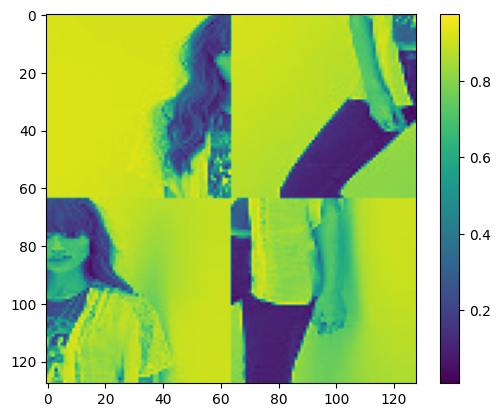

Incorrect


In [66]:
# Plotting to see the data
idx = 1000
plt.figure()
plt.imshow(testing_images[idx])
plt.colorbar()
plt.grid(False)
plt.show()
training_images.shape
type(training_labels)
training_images[1].shape
print(class_names[testing_labels[idx]])

# Evaluate Test Cases

In [67]:
test_loss, test_acc = model.evaluate(testing_images,  testing_labels, verbose=2)

print('\nTest accuracy:', test_acc)

375/375 - 1s - loss: 0.0569 - accuracy: 0.9847 - 822ms/epoch - 2ms/step

Test accuracy: 0.984666645526886


# Make Predictions

In [71]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(testing_images)

idx = 2

print(predictions[idx])

print("Prediction: {:d}".format(np.argmax(predictions[idx])))
print("Reality: {:d}".format(testing_labels[idx]))

375/375 [==============================] - 1s 2ms/step
[1.3845655e-06 9.9999857e-01]
Prediction: 1
Reality: 1


# Plotting results

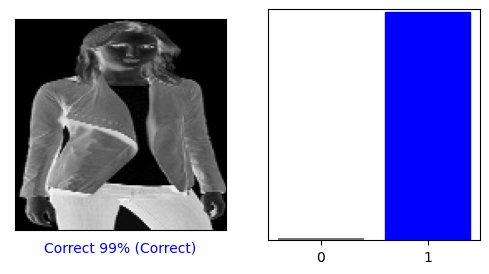

In [72]:
# Taken from https://www.tensorflow.org/tutorials/keras/classification
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(2))
  plt.yticks([])
  thisplot = plt.bar(range(2), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

i = 1
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], testing_labels, testing_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  testing_labels)
plt.show()

Plot the first X test images, their predicted labels, and the true labels.  
Color correct predictions in blue and incorrect predictions in red.

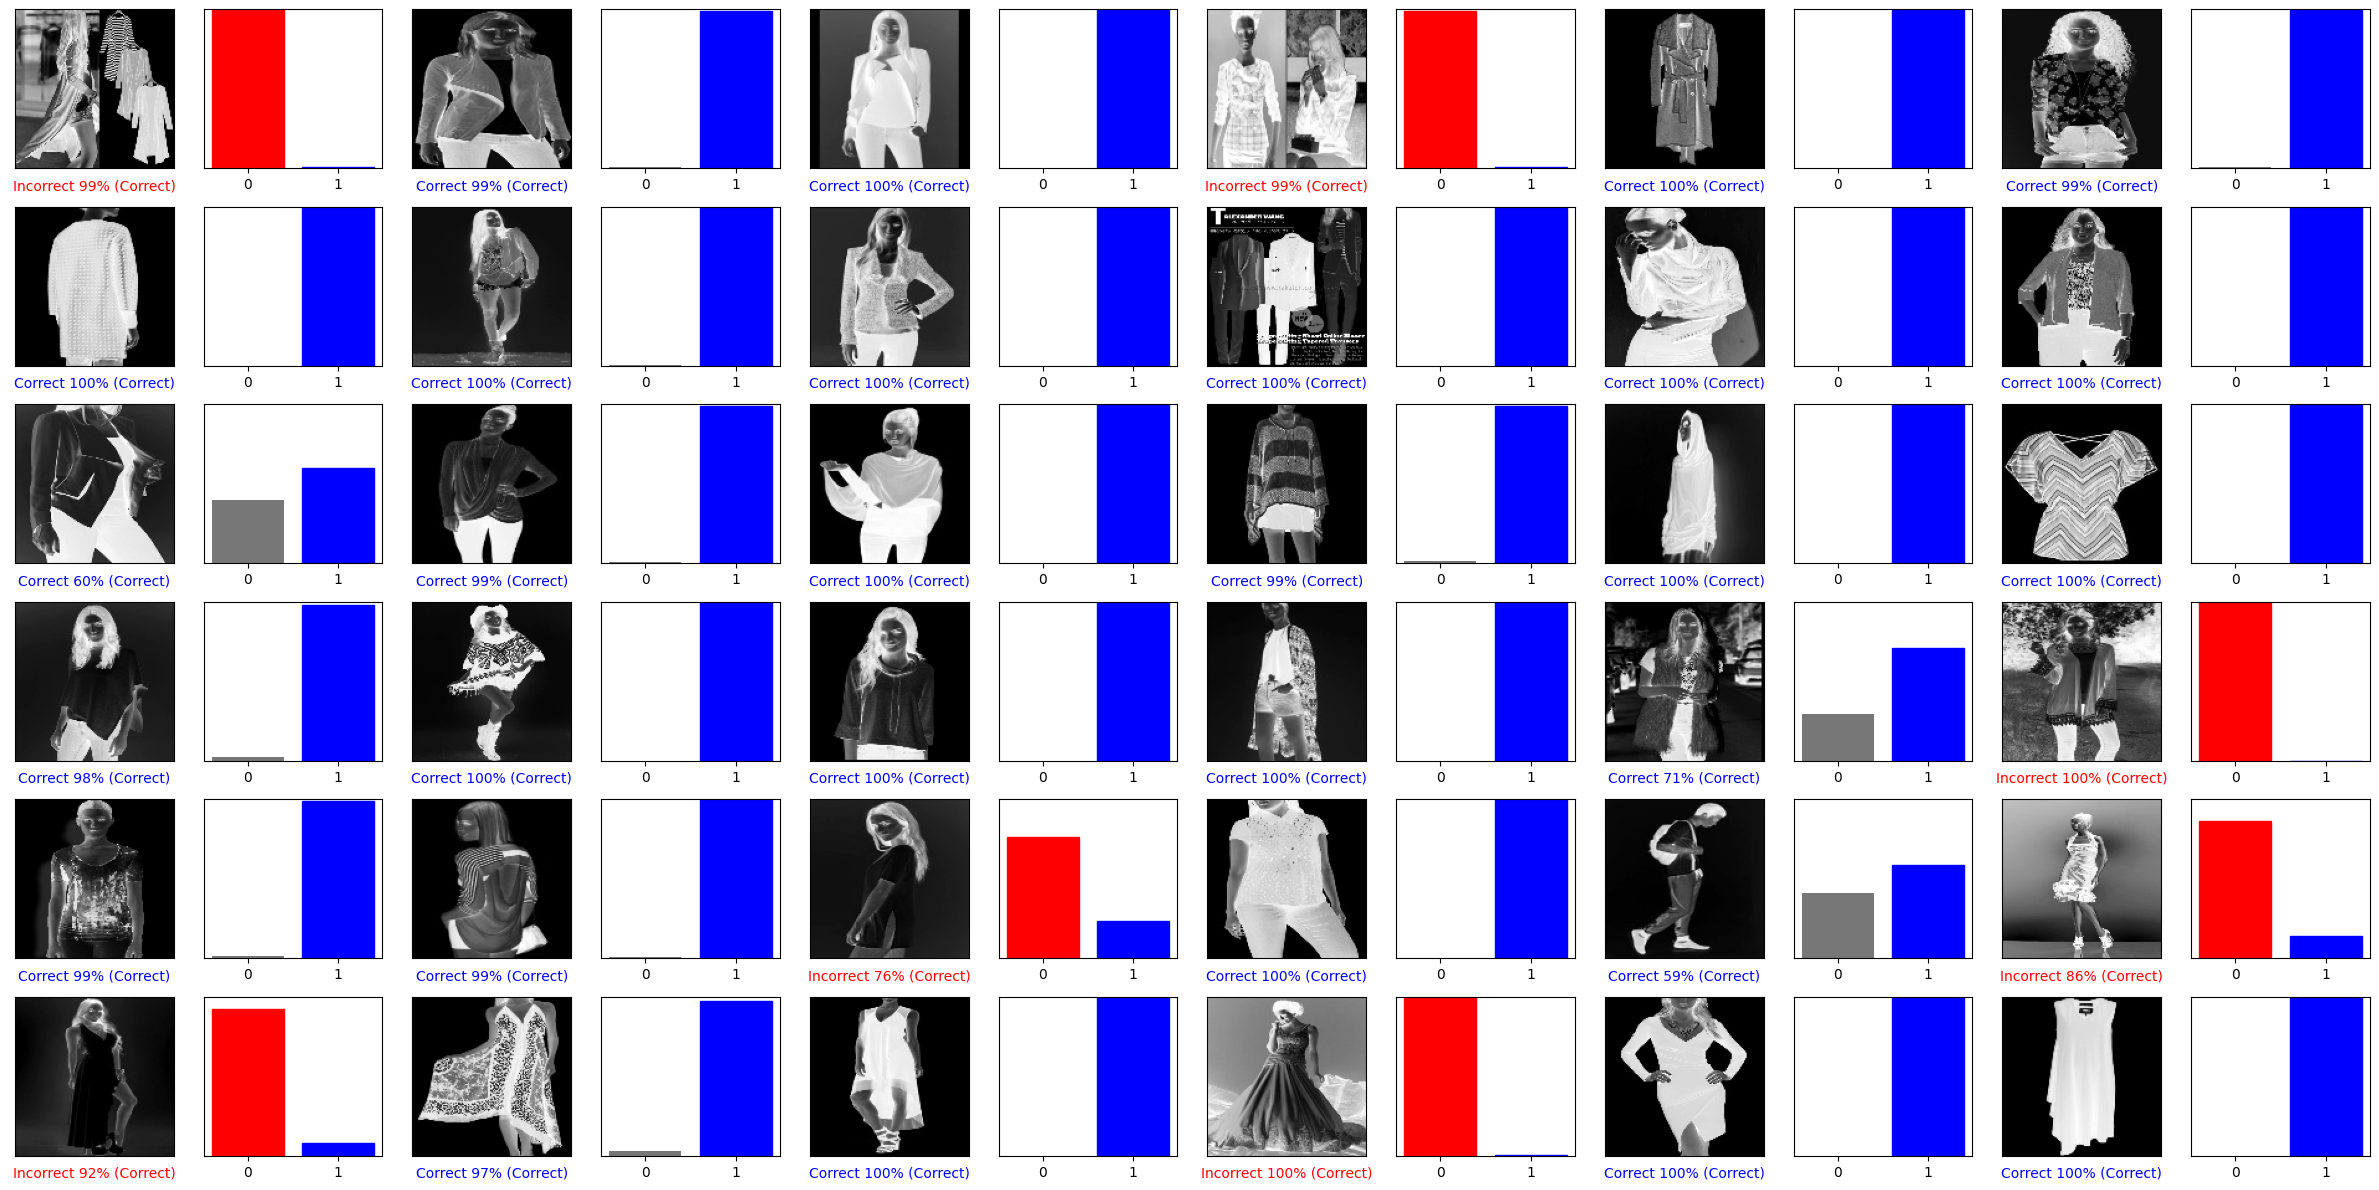

In [76]:
# Modified from https://www.tensorflow.org/tutorials/keras/classification
num_rows = 6
num_cols = 6
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], testing_labels, testing_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], testing_labels)
plt.tight_layout()
plt.show()

# Using the trained model

(128, 128)
(1, 128, 128)
1/1 [==============================] - 0s 62ms/step
[[0.0100024  0.98999757]]


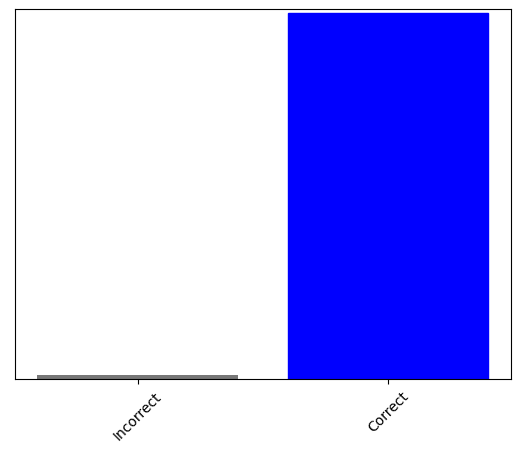

In [74]:
# Grab an image from the test dataset.
img = testing_images[1]

print(img.shape)

# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

# Now predict the correct label for this image:

predictions_single = probability_model.predict(img)

print(predictions_single)

plot_value_array(1, predictions_single[0], testing_labels)
_ = plt.xticks(range(2), class_names, rotation=45)
np.argmax(predictions_single[0])
plt.show()

# Saving the trained model

In [75]:
model.save('unscramble_model.h5')